In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring


In [2]:
filename_out    = 'output/inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_pad_x_class = 397
ndim_x_features     = 7
ndim_pad_x_features = 593

ndim_y     = 512
ndim_z     = 10
ndim_pad_zy = 478 

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x_class + ndim_x_features + ndim_pad_x_class+ ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False

lambd_fit_forw         = 10.
lambd_mmd_forw         = 50.
lambd_reconstruct      = 1.
lambd_mmd_back_class   = 100.
lambd_mmd_back_feature = 50.
lambd_max_likelihood   = 1.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 3.0
#
hidden_layer_sizes = 64
#
use_permutation = True
#
verbose_construction = False

In [3]:
def read_data(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    labels = torch.zeros(len(files), ndim_y, dtype = torch.float32)
    inputs = torch.zeros(len(files), ndim_x_class+ndim_x_features, dtype = torch.float32)
    input_keys = ['shape', 'radius', 'radius_pd','length', 'length_pd',  'volfraction']
    for i,f in enumerate(files):
        with  h5py.File(os.path.join(path,f),'r') as file:
            print(file, end = '\r')
            labels[i,:] = torch.from_numpy(file['entry/I'][()].flatten())#I_noisy
            for i_k, key in enumerate(input_keys):
                try:
                    if key == 'shape':
                        shape = file['properties'][key][()].decode("utf-8")
                        if shape == 'sphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([1,0,0]) 
                            #conditions[i, i+k]
                        elif shape == 'hardsphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([0,1,0])
                        else:
                            inputs[i, i_k:i_k+3] = torch.tensor([0,0,1])
                    elif key =='radius':
                        if shape == 'sphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([file['properties'][key][()],0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,file['properties'][key][()],0])
                        else:
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,0,file['properties'][key][()]])
                    else:
                        inputs[i, i_k+4] = file['properties'][key][()]
                except KeyError:
                    # spheres don't have all of the properties a cylinder does
                    pass
    return inputs, labels
            

In [4]:
inputs,labels = read_data('/home/slaskina/simulations')


In [5]:

# Creating data indices for training and validation splits:
dataset_size = len(labels)
indices = list(range(dataset_size))
test_size = 0.1
val_size = 0.2
test_split = int(np.floor(test_size * dataset_size))
val_split = int(np.floor(val_size * dataset_size))
np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:dataset_size-test_split-val_split], indices[dataset_size-test_split-val_split:dataset_size-test_split], indices[dataset_size-test_split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [6]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = val_sampler)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = train_sampler)

In [7]:

input1 = Ff.InputNode(ndim_x_class + ndim_pad_x_class, name='input_class')
input2 = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')

nodes = [input1]
for i in range(N_blocks):
    nodes.append(Ff.Node([nodes[-1].out0],Fm.IResNetLayer, {'internal_size':hidden_layer_sizes, 
                                                'n_internal_layers':4, 
                                                'jacobian_iterations':12,
                                                'hutchinson_samples':1, 
                                                'fixed_point_iterations':50,
                                                'lipschitz_iterations':10,
                                                'lipschitz_batchsize':10,
                                                'spectral_norm_max':0.8,
                                                }, name='ires'+str(i)))

    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='class_permute_'+str(i)))
nodes.append(input2)
nodes.append(Ff.Node([nodes[-2].out0, nodes[-1].out0], Fm.Concat, {}, name='Concat'))

for i in range(N_blocks):
    nodes.append(Ff.Node([nodes[-1].out0],Fm.IResNetLayer, {'internal_size':hidden_layer_sizes, 
                                                'n_internal_layers':3, 
                                                'jacobian_iterations':12,
                                                'hutchinson_samples':1, 
                                                'fixed_point_iterations':50,
                                                'lipschitz_iterations':10,
                                                'lipschitz_batchsize':10,
                                                'spectral_norm_max':0.8,
                                                }, name='ires_concat_'+str(i)))
    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':N_blocks+i}, name='class_permute_'+str(N_blocks+i)))
nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)
      
model.to(device)


GraphINN(
  (module_list): ModuleList(
    (0): IResNetLayer(
      (residual): Sequential(
        (0): Linear(in_features=400, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): ELU(alpha=1.0)
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): ELU(alpha=1.0)
        (8): Linear(in_features=64, out_features=64, bias=True)
        (9): ELU(alpha=1.0)
        (10): Linear(in_features=64, out_features=400, bias=True)
      )
    )
    (1): PermuteRandom()
    (2): IResNetLayer(
      (residual): Sequential(
        (0): Linear(in_features=400, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): ELU(alpha=1.0)
        (6):

In [8]:

params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
for p in params_trainable:
    p.data = init_scale * torch.randn(p.data.shape).to(device)

gamma = (final_decay)**(1./n_epochs)
optim = torch.optim.Adam(params_trainable, lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
weight_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=gamma)

def optim_step():
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def scheduler_step():
    #weight_scheduler.step()
    pass

def save(name):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [9]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)

def loss_max_likelihood(out, y):
    jac = jacobian(run_forward=False)

    neg_log_likeli = ( 0.5 / y_uncertainty_sigma**2 * torch.sum((out[:, -ndim_y:]       - y[:, -ndim_y:])**2, 1)
                     + 0.5 / zeros_noise_scale**2   * torch.sum((out[:, ndim_z:-ndim_y] - y[:, ndim_z:-ndim_y])**2, 1)
                     + 0.5 * torch.sum(out[:, :ndim_z]**2, 1)
                     - jac)

    return lambd_max_likelihood * torch.mean(neg_log_likeli)

def loss_forward_mmd(out, y):
    # Shorten output, and remove gradients wrt y, for latent loss
    # [z,y] only
    output_block_grad = torch.cat((out[:, :ndim_z],
                                   out[:, -ndim_y:].data), dim=1) 
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

    l_forw_fit = lambd_fit_forw * losses.l2_fit(out[:, ndim_z:], y[:, ndim_z:])
    l_forw_mmd = lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))

    return l_forw_fit, l_forw_mmd

def loss_backward_mmd(x_class, x_features, y):
    [x_samples_class, x_samples_features], x_samples_jac = model(y, rev=True, jac = False) 
    MMD_class = losses.backward_mmd(x_class, x_samples_class) 
    MMD_features = losses.backward_mmd(x_features, x_samples_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
    return lambd_mmd_back_class * torch.mean(MMD_class)+lambd_mmd_back_feature * torch.mean(MMD_features)


def loss_reconstruction(out_y, x_class, x_features):
    cat_inputs = [out_y[:, :ndim_z] + add_z_noise * noise_batch(ndim_z)] # list with 1 tensor
    
    if ndim_pad_zy:
        cat_inputs.append(out_y[:, ndim_z:-ndim_y] + add_pad_noise * noise_batch(ndim_pad_zy)) # list with 2 tensor
    cat_inputs.append(out_y[:, -ndim_y:] + add_y_noise * noise_batch(ndim_y)) # list with 3 tensors
    [x_reconstructed_class, x_reconstructed_features], x_reconstructed_jac = model(torch.cat(cat_inputs, 1), rev=True, jac = False) # concatenate list elements along axis 1
    return lambd_reconstruct * (losses.l2_fit(x_reconstructed_class[:, :ndim_pad_x_class], x_class[:,:ndim_pad_x_class]) + losses.l2_fit(x_reconstructed_features[:,:ndim_pad_x_features], x_features[:,:ndim_pad_x_features]) )# needs fix

def train_epoch(i_epoch, test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for x, y in loader:

        if batch_idx > n_its_per_epoch:
            break
        batch_losses = []

        batch_idx += 1

        x, y = x.to(device), y.to(device)

        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
        if ndim_pad_x_class:
            x_class = torch.cat((x[:,:3], add_pad_noise * noise_batch(ndim_pad_x_class)), dim=1)
        
        if ndim_pad_x_features:
            x_features = torch.cat((x[:,3:], add_pad_noise * noise_batch(ndim_pad_x_features)), dim=1)
        if ndim_pad_zy:
            y = torch.cat((add_pad_noise * noise_batch(ndim_pad_zy), y), dim=1)
        y = torch.cat((noise_batch(ndim_z), y), dim=1)

        out_y, out_y_jac = model([x_class,x_features], jac  = False)
        # tuple with output[0] and jacobian[1]
        if train_max_likelihood:
            batch_losses.append(loss_max_likelihood(out_y, y))

        if train_forward_mmd:
            batch_losses.extend(loss_forward_mmd(out_y, y))

        if train_backward_mmd:
            batch_losses.append(loss_backward_mmd(x_class,x_features, y))

        if train_reconstruction:
            batch_losses.append(loss_reconstruction(out_y.data, x_class, x_features))

        l_total = sum(batch_losses)
        loss_history.append([l.item() for l in batch_losses]) # lisr of lists: list for each batch

        if not test:
            l_total.backward()
            optim_step()

    if test:
        monitoring.show_hist(out_y[:, :ndim_z])
        monitoring.show_cov(out_y[:, :ndim_z])
        if test_time_functions:
            out_x_class, out_x_features, out_x_jac = model(y, rev=True, jac = False) 
            for f in test_time_functions:
                f(out_x_class, out_x_features, out_y, x_class,x_features, y)

        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train():
    monitoring.restart()

    try:
        monitoring.print_config()
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(i_epoch) # mean over batches
            test_losses  = train_epoch(i_epoch, test=True)
            t = np.concatenate([train_losses, test_losses])
            monitoring.show_loss(t)
            scheduler_step() 

    except:
        save(filename_out + '_ABORT')
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out)



In [10]:
train()


Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [11]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes, create_table_from_outcome

In [12]:
def make_prediction(labels, model):
    y = torch.cat((add_pad_noise * torch.randn( len(labels), ndim_pad_zy).to('cuda'), labels.to('cuda')), dim=1)
    y = torch.cat((torch.randn( len(labels), ndim_z).to('cuda'), y), dim=1)
    [pred_class, pred_features], _ = model(y, rev = True)  # output of NN without padding
    return np.concatenate((pred_class.cpu().detach()[:,:ndim_x_class], pred_features.cpu().detach()[:, :ndim_x_features]), axis=1)


In [13]:
df_train = create_table_from_outcome(make_prediction(labels[train_indices], model), inputs[train_indices])
df_val = create_table_from_outcome(make_prediction(labels[val_indices],model), inputs[val_indices]) 
df_test = create_table_from_outcome(make_prediction(labels[test_indices], model), inputs[test_indices])

Accuracy is 33.45%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0177, hardsphere: 0.0128 and cylinder: 0.0157
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0014, hardsphere: 0.0012 and cylinder: 0.0013
MSE for cylinder length for correctly identified instances: 1.3364
MSE for cylinder length polydispersity for correctly identified instances: 0.0033
MSE for cylinder length for correctly identified instances: 0.0134


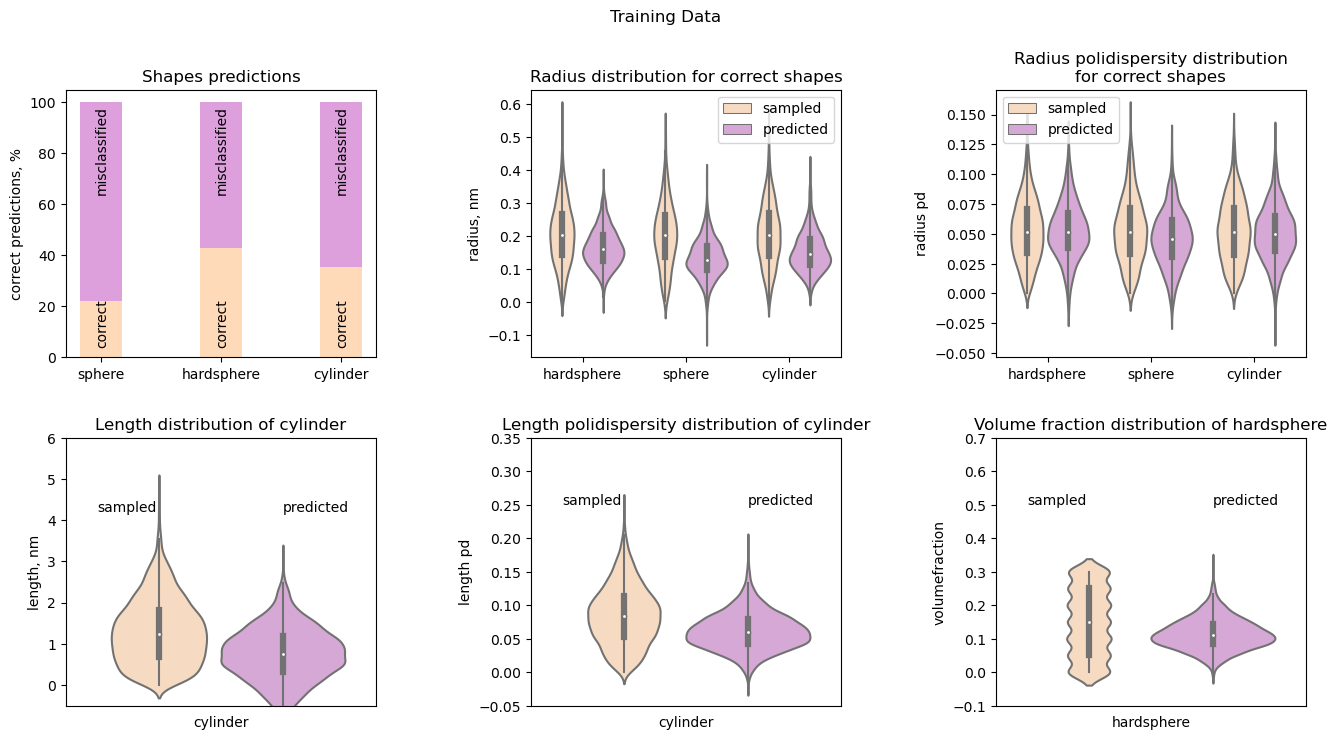

In [14]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 32.93%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0158, hardsphere: 0.0132 and cylinder: 0.0162
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0011, hardsphere: 0.0012 and cylinder: 0.0010
MSE for cylinder length for correctly identified instances: 1.1772
MSE for cylinder length polydispersity for correctly identified instances: 0.0035
MSE for cylinder length for correctly identified instances: 0.0146


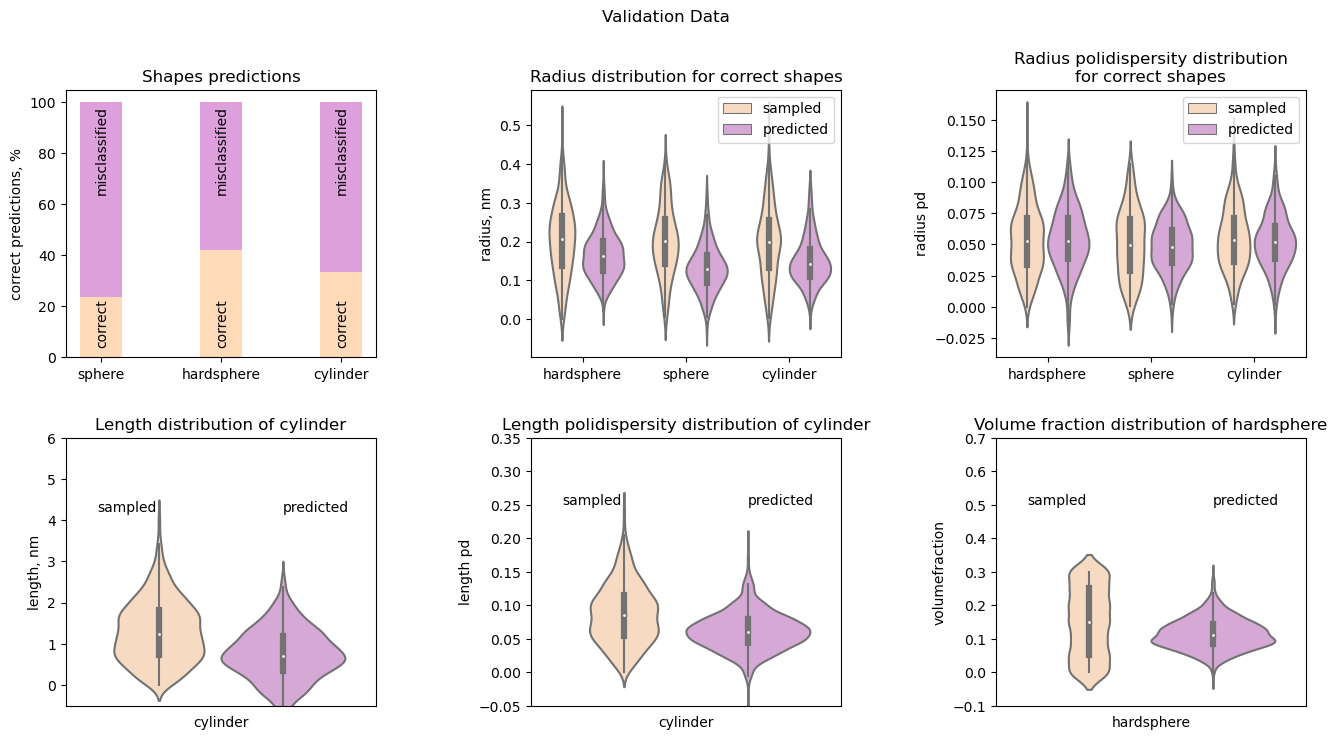

In [15]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 33.07%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0158, hardsphere: 0.0157 and cylinder: 0.0158
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0011, hardsphere: 0.0014 and cylinder: 0.0014
MSE for cylinder length for correctly identified instances: 1.3579
MSE for cylinder length polydispersity for correctly identified instances: 0.0039
MSE for cylinder length for correctly identified instances: 0.0136


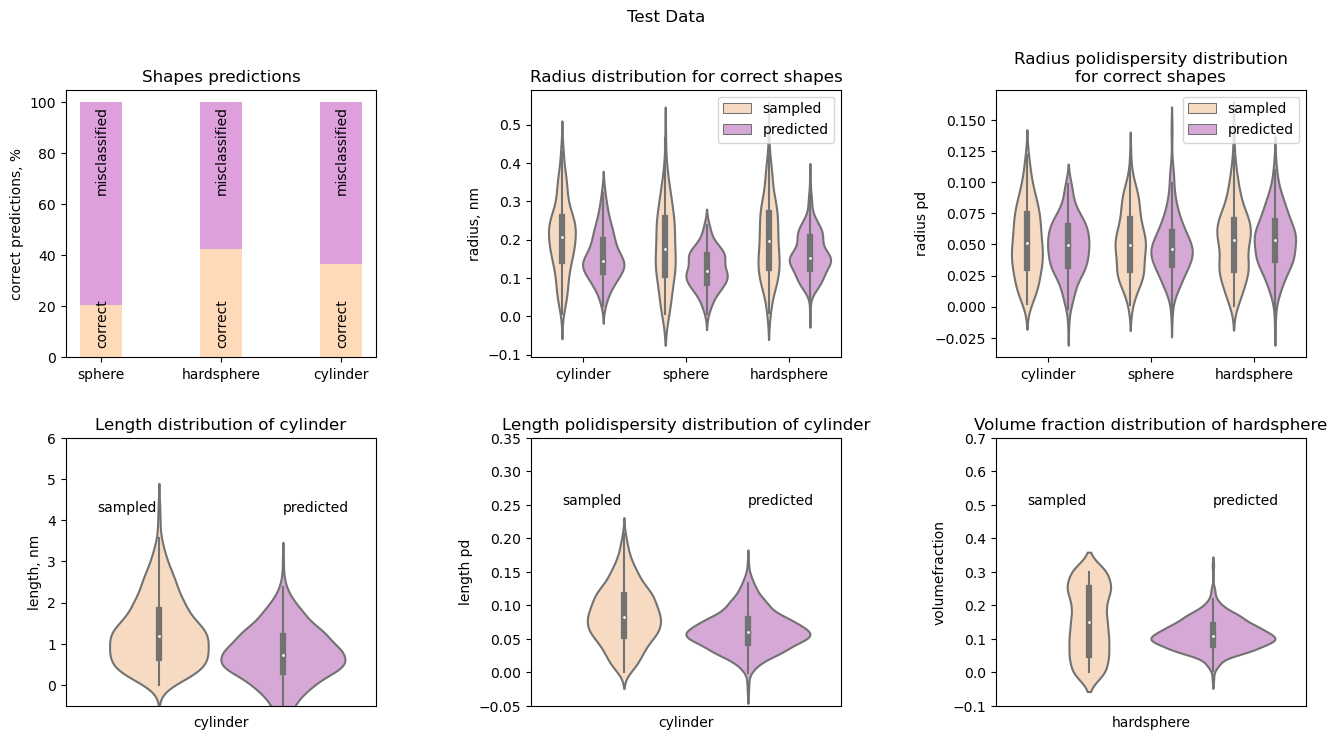

In [16]:
plot_outcomes_identified(df_test, 'Test')

In [17]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

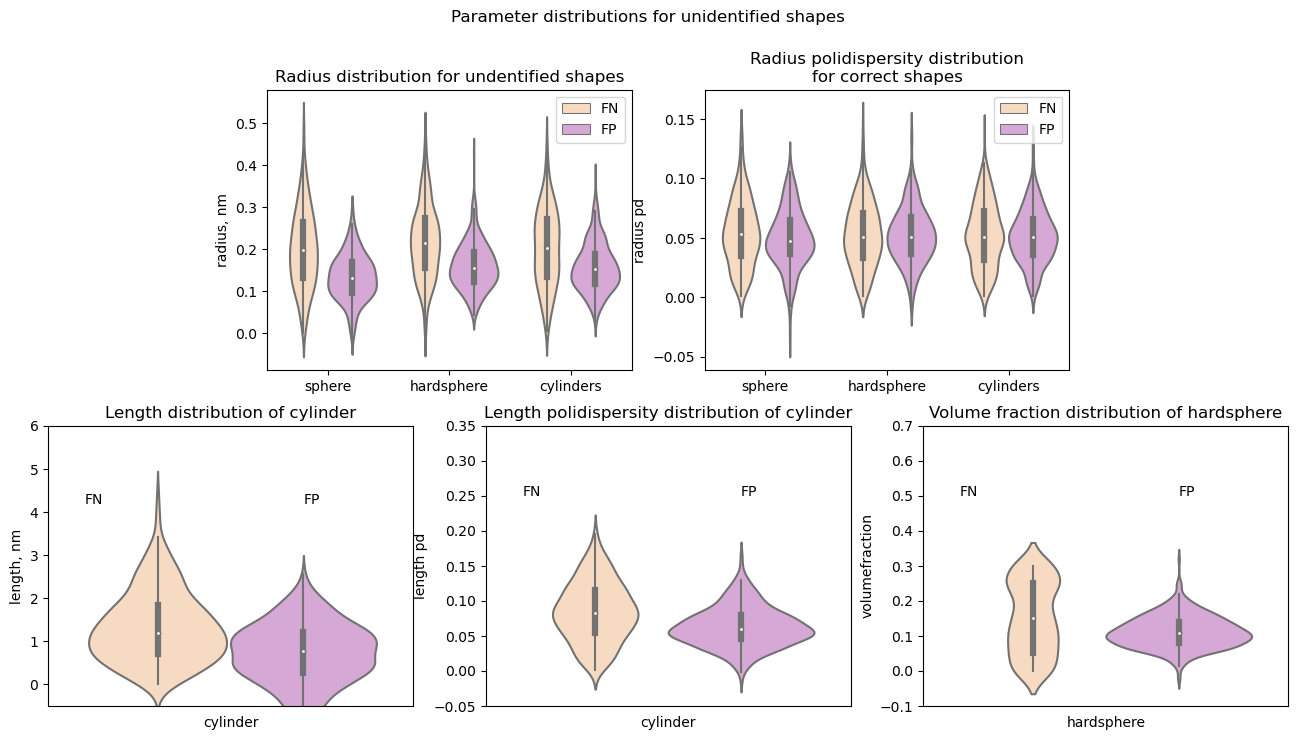

In [18]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

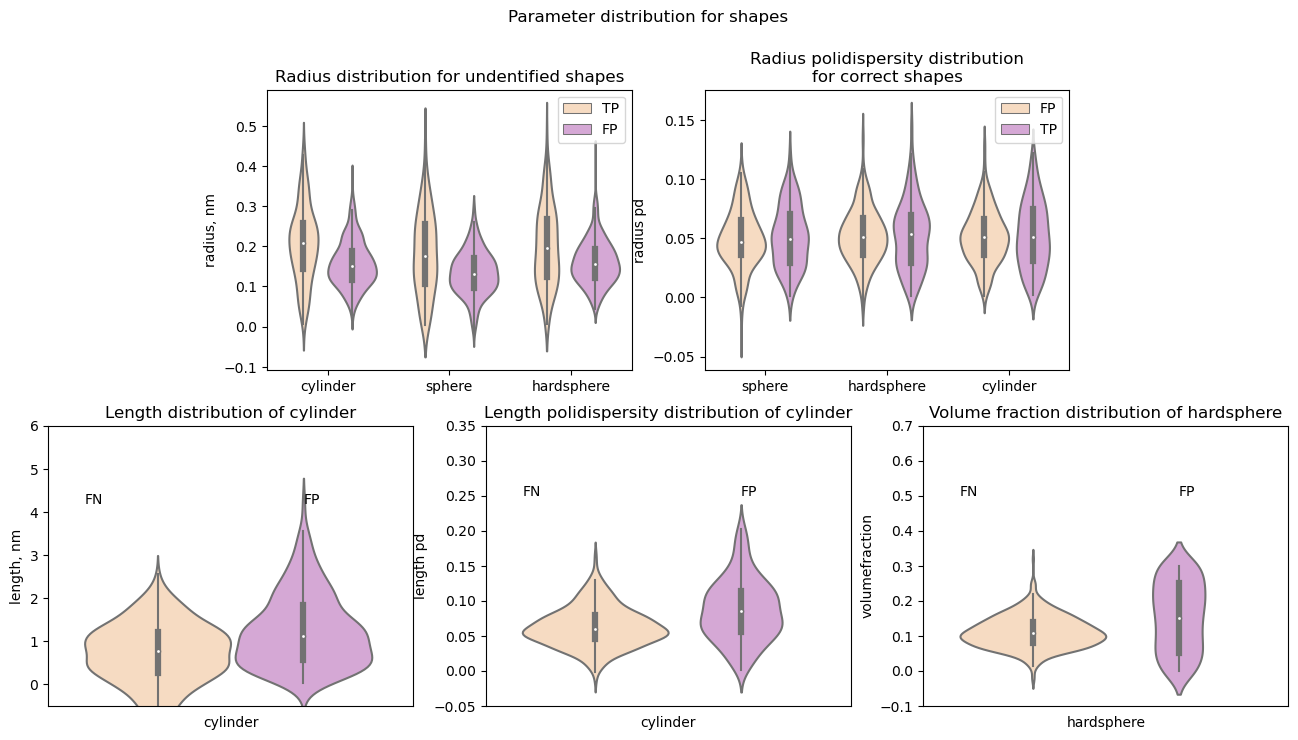

In [19]:
describe_positive_shapes(df_test)

## now look at the unidentified shapes more closely

In [20]:
def assign_class(row):
    if row[0]==1:
        return  'sphere'
    elif row[1] == 1:
        return 'hardsphere'
    elif row[2] == 1:
        return 'cylinder'
shapes_dict = {0:'sphere', 1:'hardsphere', 2:'cylinder'}

In [21]:
prediction_class = pd.DataFrame(make_prediction(labels[test_indices], model)[:,0:3])
prediction_class['true_class'] = pd.DataFrame(inputs[test_indices][:,0:3]).apply(assign_class, axis=1)
prediction_class['prediction'] = prediction_class[[0,1,2]].idxmax(axis=1)
prediction_class.replace({'prediction':shapes_dict}, inplace = True)

In [22]:
unidentified_shapes = prediction_class[prediction_class.true_class != prediction_class.prediction]

In [23]:
unidentified_shapes

,0,1,2,true_class,prediction
1,0.012156,0.707793,0.196635,cylinder,hardsphere
3,0.474629,0.188045,0.376635,hardsphere,sphere
4,0.112949,0.673793,0.212477,sphere,hardsphere
6,0.824521,0.720065,-0.464988,hardsphere,sphere
7,0.047084,0.789423,0.090089,cylinder,hardsphere
...,...,...,...,...,...
1490,-0.088223,0.811342,0.220666,sphere,hardsphere
1491,0.349979,-0.163738,0.758619,sphere,cylinder
1494,0.418982,-0.064988,0.544721,sphere,cylinder
1495,0.265111,0.215237,0.590140,hardsphere,cylinder


In [24]:
import seaborn as sns

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


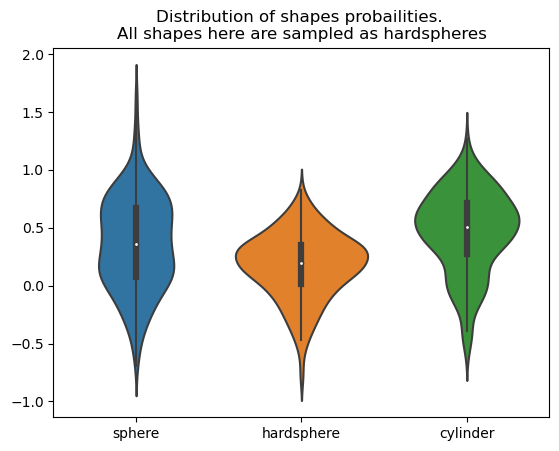

In [25]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'hardsphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as hardspheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


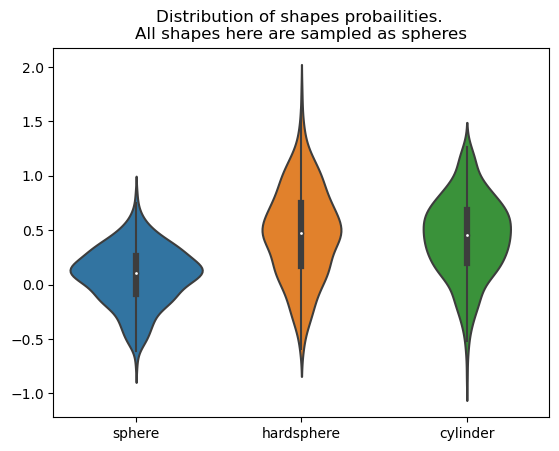

In [26]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'sphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


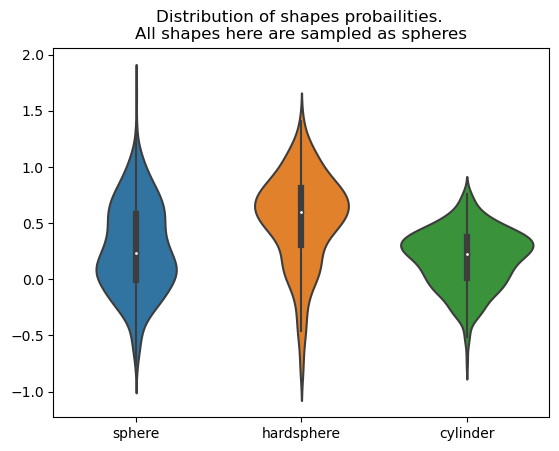

In [27]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'cylinder'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

In [28]:
unidentified_shapes

,0,1,2,true_class,prediction
1,0.012156,0.707793,0.196635,cylinder,hardsphere
3,0.474629,0.188045,0.376635,hardsphere,sphere
4,0.112949,0.673793,0.212477,sphere,hardsphere
6,0.824521,0.720065,-0.464988,hardsphere,sphere
7,0.047084,0.789423,0.090089,cylinder,hardsphere
...,...,...,...,...,...
1490,-0.088223,0.811342,0.220666,sphere,hardsphere
1491,0.349979,-0.163738,0.758619,sphere,cylinder
1494,0.418982,-0.064988,0.544721,sphere,cylinder
1495,0.265111,0.215237,0.590140,hardsphere,cylinder
